In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint, uniform
from modfunctions import binning, plot_feature_importance, save_plot, train_model_GridSearch, train_model_RandomizedSearch, plot_roc, export_file, record_results

## Load data

In [2]:
wine_path='../0. Project Data/Processed Data/2. scaled'
r_train=pd.read_csv(wine_path + '/red_train_scaled.csv', sep=',')
r_test=pd.read_csv(wine_path + '/red_test_scaled.csv', sep=',')
w_train=pd.read_csv(wine_path + '/white_train_scaled.csv', sep=',')
w_test=pd.read_csv(wine_path + '/white_test_scaled.csv', sep=',')

## Binning data

Our response variable comes from a 'quality' distribution that ranges from 0-10. In order to apply a binary Logistic regression model to this dataset, we have to bin our response variable into 'low' and 'high' quality. Here we bin the 0-6 quality wines into 'low' and the 7-10 quality wines into 'high'.

In [3]:
for data in [r_train, r_test, w_train, w_test]:
    binning(data)

## Modeling Red Wine

In [4]:
y_train_red= r_train['quality_bin']
X_train_red= r_train.drop(['quality', 'quality_bin'], axis=1)
y_test_red=r_test['quality_bin']
X_test_red=r_test.drop(['quality', 'quality_bin'], axis=1)
num_features=X_test_red.shape[1]
red_scores=[]

### Logistic Regression

We set up a pipeline that includes scaling the data using RobustScaler and a grid search over the the parameters penalty (lasso vs ridge regression regularization) and C (regularization strength)

In [5]:
LR_steps=[('LogReg', LogisticRegression(solver='liblinear'))]
LR_parameters= {'LogReg__penalty': ['l1', 'l2'],
                'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0,1000.0]
               }
LR_cv_red=train_model_GridSearch(X_train_red, y_train_red, LR_steps, LR_parameters)
LR_cv_red.best_params_

{'LogReg__C': 10.0, 'LogReg__penalty': 'l2'}

#### Logistic Regression Feature Importance

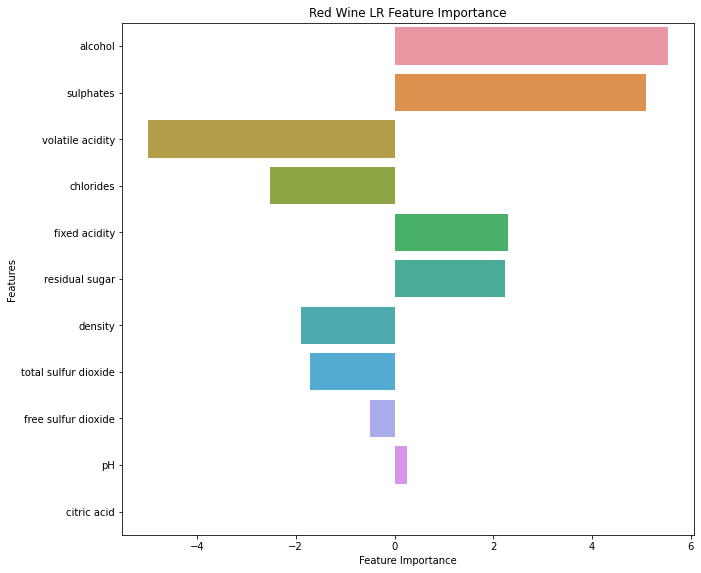

In [6]:
importance=LR_cv_red.best_estimator_.steps[0][1].coef_[0]
pfi=plot_feature_importance(importance, X_train_red.columns, 'Red Wine LR')
save_plot(pfi, './Model Metrics/Red Wine/Feature Importance/Red_Wine_LR.png')

#### Logistic Regression ROC Curve

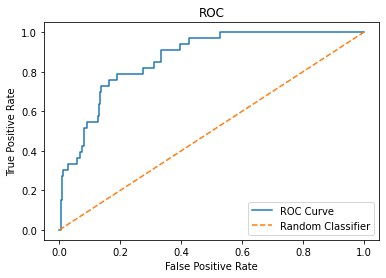

In [7]:
plot_roc(LR_cv_red, X_test_red, y_test_red)

In [8]:
LR_results_red=record_results('Logistic Regression', LR_cv_red, X_test_red, y_test_red)
red_scores.append(LR_results_red)

### PCA with Logistic Regression

This pipeline is the same as the previous but with added PCA preprocessing step.

In [9]:
PCA_LR_steps=[('pca',PCA()),('LogReg', LogisticRegression(solver='liblinear'))]
PCA_LR_parameters={'pca__n_components':list(np.arange(1,num_features+1)),
                   'LogReg__penalty': ['l1', 'l2'],
                   'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0,1000.0]
                  }
PCA_LR_cv_red=train_model_GridSearch(X_train_red, y_train_red, PCA_LR_steps, PCA_LR_parameters)
PCA_LR_cv_red.best_params_

{'LogReg__C': 10.0, 'LogReg__penalty': 'l2', 'pca__n_components': 9}

#### PCA Logistic Regression Feature Importance

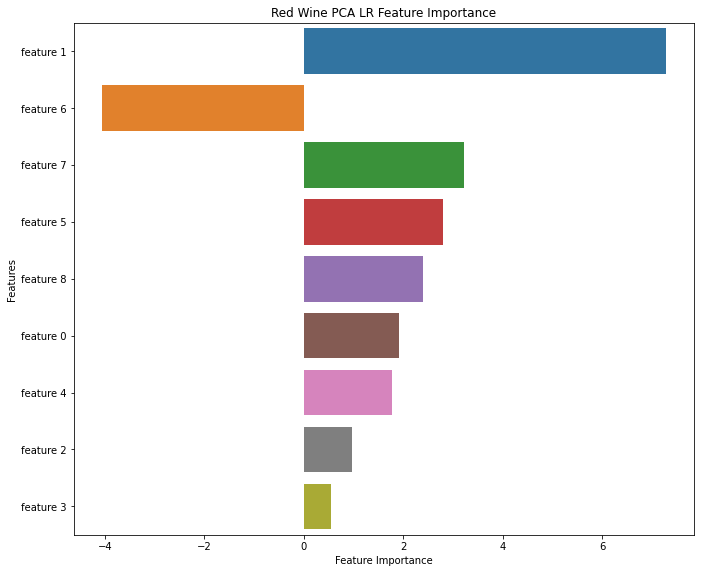

In [10]:
importance=PCA_LR_cv_red.best_estimator_.steps[1][1].coef_[0]
pfi=plot_feature_importance(importance, ['feature ' + str(i) for i in range(len(importance))], 'Red Wine PCA LR')
save_plot(pfi, './Model Metrics/Red Wine/Feature Importance/Red_Wine_PCA_LR.png')

#### PCA Logistic Regression ROC Curve

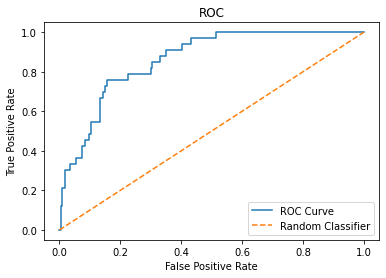

In [11]:
plot_roc(PCA_LR_cv_red, X_test_red, y_test_red)

In [12]:
PCA_LR_results_red=record_results('PCA Logistic Regression', PCA_LR_cv_red, X_test_red, y_test_red)
red_scores.append(PCA_LR_results_red)

### Random Forest

We set up a Random Forest model that employs a RandomizedSearch CV over the the parameters 

n_estimators : number of trees in the forest

max_depth : maximum depth of the tree

min_samples_split : minimum number of samples required to split a node

min_samples_leaf : minimum number of samples required to be at a leaf node

max_features : number of features to consider when looking for the best split

criterion : loss function to measure the quality of a split

In [13]:
RF_steps=[('randomForest', RandomForestClassifier())]
RF_parameters={'randomForest__n_estimators': randint(20, 300), 
             'randomForest__max_depth': randint(10,100),
             'randomForest__min_samples_split': randint(2,10),
             'randomForest__min_samples_leaf' : randint(1,10),
             'randomForest__max_features' : np.arange(num_features)+1,
             'randomForest__criterion': ['gini', 'entropy']
              }
RF_cv_red=train_model_RandomizedSearch(X_train_red, y_train_red, RF_steps, RF_parameters)
RF_cv_red.best_params_

{'randomForest__criterion': 'entropy',
 'randomForest__max_depth': 68,
 'randomForest__max_features': 3,
 'randomForest__min_samples_leaf': 9,
 'randomForest__min_samples_split': 7,
 'randomForest__n_estimators': 87}

#### Random Forest Feature Importance

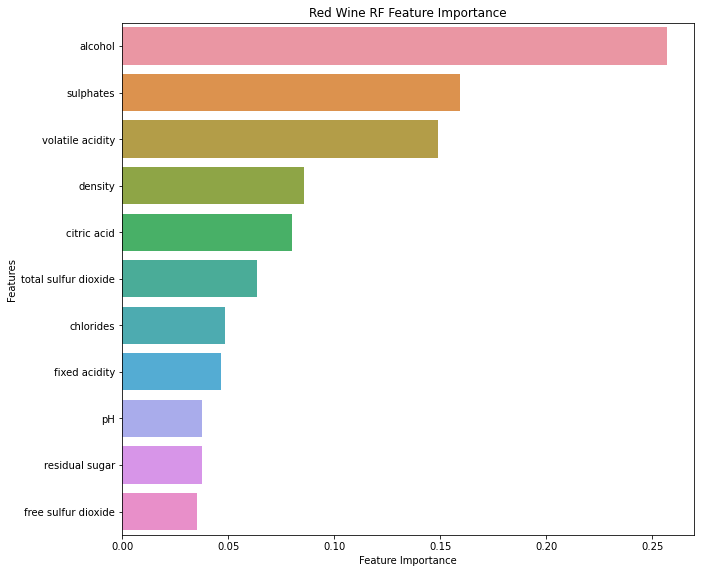

In [14]:
importance=RF_cv_red.best_estimator_.steps[0][1].feature_importances_
pfi=plot_feature_importance(importance, X_train_red.columns, 'Red Wine RF')
save_plot(pfi, './Model Metrics/Red Wine/Feature Importance/Red_Wine_RF.png')

#### Random Forest ROC Curve

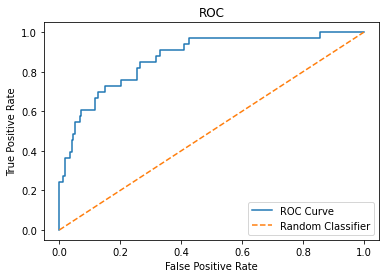

In [15]:
plot_roc(RF_cv_red, X_test_red, y_test_red)

In [16]:
RF_results_red=record_results('Random Forest', RF_cv_red, X_test_red, y_test_red)
red_scores.append(RF_results_red)

### Gradient Boosted Tree

We set up a Gradient Boosted Tree model that employs a RandomizedSearchCV over the the parameters 

learning_rate : how fast individual trees learn 

n_estimators : number of boosted trees

subsample : fraction of data used to train each tree

min_samples_split : minimum number of samples required to split a node

max_depth : max depth of a tree

max_features : number of features to consider when looking for the best split

min_samples_leaf : minimum number of samples required to be at a leaf node

In [17]:
GBT_steps=[('GBT', GradientBoostingClassifier())]
GBT_parameters= {'GBT__learning_rate': uniform(0,3),
                 'GBT__n_estimators': randint(1,1000),
                 'GBT__subsample' : uniform(0,1),
                 'GBT__min_samples_split': randint(2,10),
                 'GBT__max_depth' : randint(1,10),
                 'GBT__max_features' : np.arange(num_features)+1,
                 'GBT__min_samples_leaf': randint(1,10)
                }
GBT_cv_red=train_model_RandomizedSearch(X_train_red, y_train_red, GBT_steps, GBT_parameters)
GBT_cv_red.best_params_

{'GBT__learning_rate': 0.3516205136085174,
 'GBT__max_depth': 6,
 'GBT__max_features': 2,
 'GBT__min_samples_leaf': 5,
 'GBT__min_samples_split': 5,
 'GBT__n_estimators': 771,
 'GBT__subsample': 0.521010875426266}

#### Gradient Boosted Trees Feature Importance

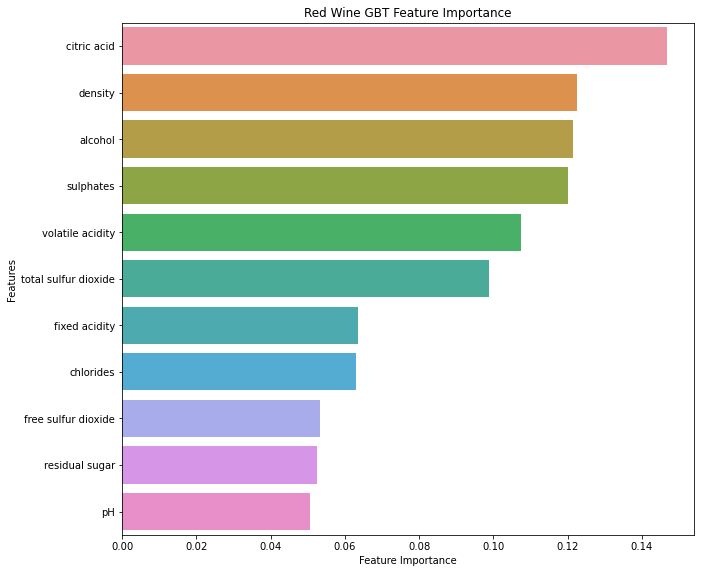

In [18]:
importance=GBT_cv_red.best_estimator_.steps[0][1].feature_importances_
pfi=plot_feature_importance(importance, X_train_red.columns, 'Red Wine GBT')
save_plot(pfi, './Model Metrics/Red Wine/Feature Importance/Red_Wine_GBT.png')

#### Gradient Boosted Tree ROC Curve

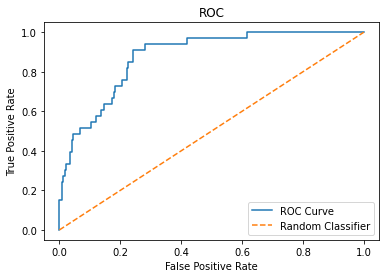

In [19]:
plot_roc(GBT_cv_red, X_test_red, y_test_red)

In [20]:
GBT_results_red=record_results('Gradient Boosted Tree', GBT_cv_red, X_test_red, y_test_red)
red_scores.append(GBT_results_red)

### Red Wine Results

In [21]:
red_results= pd.DataFrame(red_scores, columns=['Model Name', 'f1 score', 'test_acc', 'roc'])
red_results.index.name='Red Wine'
red_results

,Model Name,f1 score,test_acc,roc
Red Wine,,,,
0,Logistic Regression,0.415094,0.886029,0.867377
1,PCA Logistic Regression,0.415094,0.886029,0.861671
2,Random Forest,0.461538,0.897059,0.869913
3,Gradient Boosted Tree,0.533333,0.897059,0.877013


## Modeling White Wine

In [22]:
y_train_white= w_train['quality_bin']
X_train_white= w_train.drop(['quality', 'quality_bin'], axis=1)
y_test_white=w_test['quality_bin']
X_test_white=w_test.drop(['quality', 'quality_bin'], axis=1)
num_features=X_test_white.shape[1]
white_scores=[]

### Logistic Regression

In [23]:
LR_steps=[('LogReg', LogisticRegression(solver='liblinear'))]
LR_parameters= {'LogReg__penalty': ['l1', 'l2'],
                'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0,1000.0]
               }
LR_cv_white=train_model_GridSearch(X_train_white, y_train_white, LR_steps, LR_parameters)
LR_cv_white.best_params_

{'LogReg__C': 1000.0, 'LogReg__penalty': 'l1'}

#### Logistic Regression Feature Importance

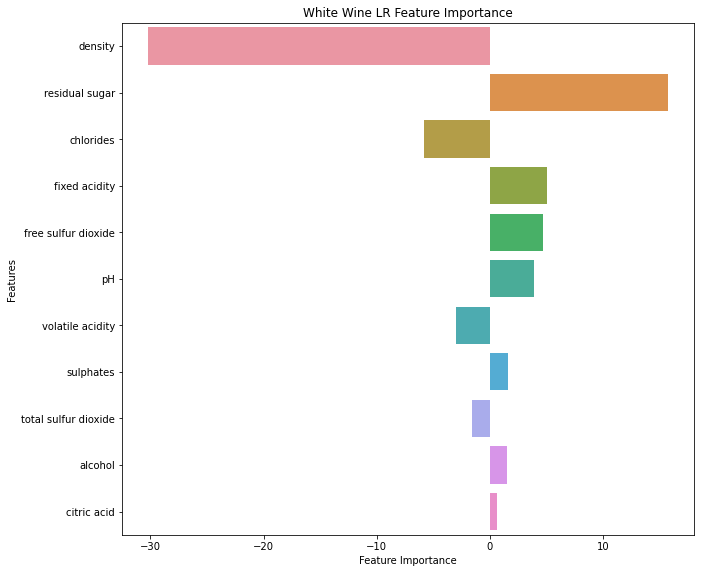

In [24]:
importance=LR_cv_white.best_estimator_.steps[0][1].coef_[0]
pfi=plot_feature_importance(importance, X_train_white.columns, 'White Wine LR')
save_plot(pfi, './Model Metrics/White Wine/Feature Importance/White_Wine_LR.png')

#### Logistic Regression ROC Curve

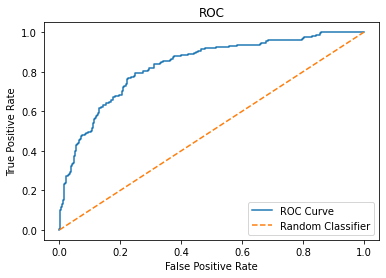

In [25]:
plot_roc(LR_cv_white, X_test_white, y_test_white)

In [26]:
LR_results_white=record_results('Logistic Regression', LR_cv_white, X_test_white, y_test_white)
white_scores.append(LR_results_white)

### PCA with Logistic Regression

In [27]:
PCA_LR_steps=[('pca',PCA()),('LogReg', LogisticRegression(solver='liblinear'))]
PCA_LR_parameters={'pca__n_components':list(np.arange(1,num_features+1)),
                   'LogReg__penalty': ['l1', 'l2'],
                   'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0,1000.0]
                  }
PCA_LR_cv_white=train_model_GridSearch(X_train_white, y_train_white, PCA_LR_steps, PCA_LR_parameters)
PCA_LR_cv_white.best_params_

{'LogReg__C': 1000.0, 'LogReg__penalty': 'l1', 'pca__n_components': 11}

#### PCA Logistic Regression Feature Importance

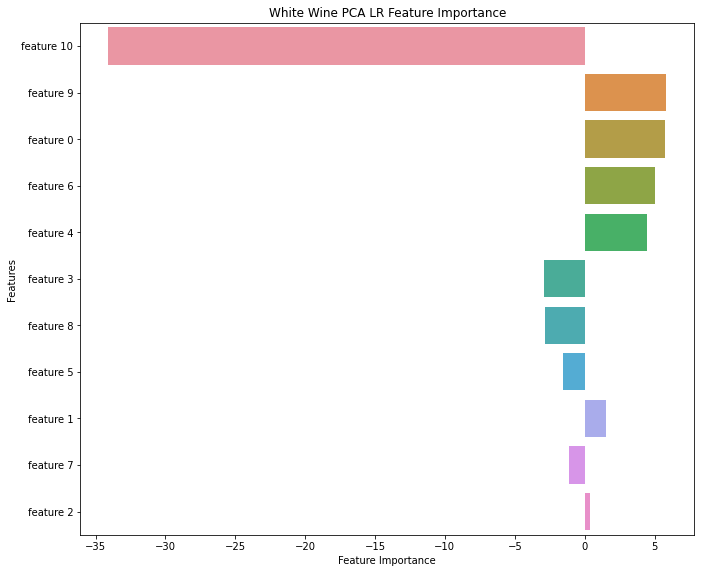

In [28]:
importance=PCA_LR_cv_white.best_estimator_.steps[1][1].coef_[0]
pfi=plot_feature_importance(importance, ['feature ' + str(i) for i in range(len(importance))], 'White Wine PCA LR')
save_plot(pfi, './Model Metrics/White Wine/Feature Importance/White_Wine_PCA_LR.png')

#### PCA Logistic Regression ROC Curve

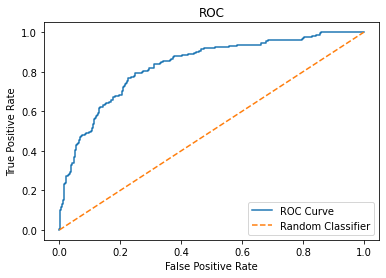

In [29]:
plot_roc(PCA_LR_cv_white, X_test_white, y_test_white)

In [30]:
PCA_LR_results_white=record_results('PCA Logistic Regression', PCA_LR_cv_white, X_test_white, y_test_white)
white_scores.append(PCA_LR_results_white)

### Random Forest

In [31]:
RF_steps=[('randomForest', RandomForestClassifier())]
RF_parameters={'randomForest__n_estimators': randint(20, 300), 
             'randomForest__max_depth': randint(10,100),
             'randomForest__min_samples_split': randint(2,10),
             'randomForest__min_samples_leaf' : randint(1,10),
             'randomForest__max_features' : np.arange(num_features)+1,
             'randomForest__criterion': ['gini', 'entropy']
              }
RF_cv_white=train_model_RandomizedSearch(X_train_white, y_train_white, RF_steps, RF_parameters)
RF_cv_white.best_params_

{'randomForest__criterion': 'entropy',
 'randomForest__max_depth': 79,
 'randomForest__max_features': 1,
 'randomForest__min_samples_leaf': 3,
 'randomForest__min_samples_split': 4,
 'randomForest__n_estimators': 298}

#### Random Forest Feature Importance

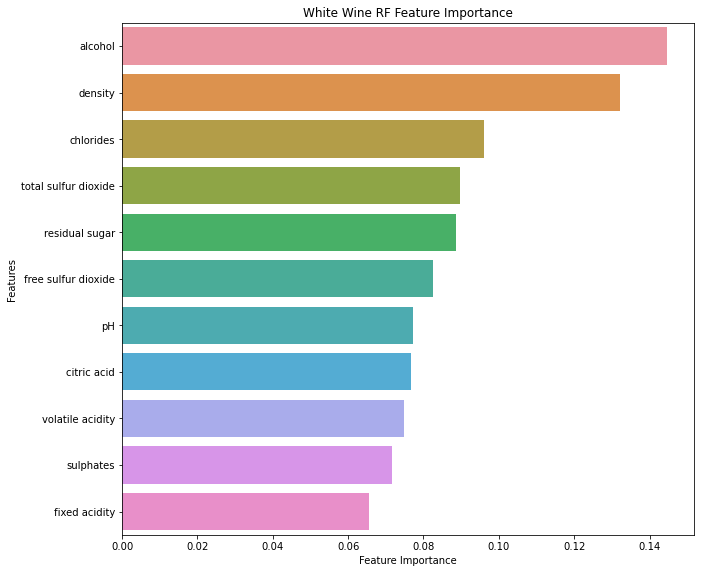

In [32]:
importance=RF_cv_white.best_estimator_.steps[0][1].feature_importances_
pfi=plot_feature_importance(importance, X_train_white.columns, 'White Wine RF')
save_plot(pfi, './Model Metrics/White Wine/Feature Importance/White_Wine_RF.png')

#### Random Forest ROC Curve

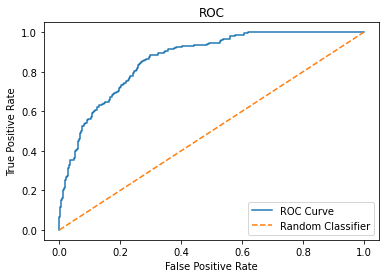

In [33]:
plot_roc(RF_cv_white, X_test_white, y_test_white)

In [34]:
RF_results_white=record_results('Random Forest', RF_cv_white, X_test_white, y_test_white)
white_scores.append(RF_results_white)

### Gradient Boosted Tree

In [35]:
GBT_steps=[('GBT', GradientBoostingClassifier())]
GBT_parameters= {'GBT__learning_rate': uniform(0,3),
                 'GBT__n_estimators': randint(1,1000),
                 'GBT__subsample' : uniform(0,1),
                 'GBT__min_samples_split': randint(2,10),
                 'GBT__max_depth' : randint(1,10),
                 'GBT__max_features' : np.arange(num_features)+1,
                 'GBT__min_samples_leaf': randint(1,10)
                }
GBT_cv_white=train_model_RandomizedSearch(X_train_white, y_train_white, GBT_steps, GBT_parameters)
GBT_cv_white.best_params_

{'GBT__learning_rate': 0.20234590539015518,
 'GBT__max_depth': 8,
 'GBT__max_features': 9,
 'GBT__min_samples_leaf': 9,
 'GBT__min_samples_split': 9,
 'GBT__n_estimators': 28,
 'GBT__subsample': 0.9839275636184652}

#### Gradient Boosted Trees Feature Importance

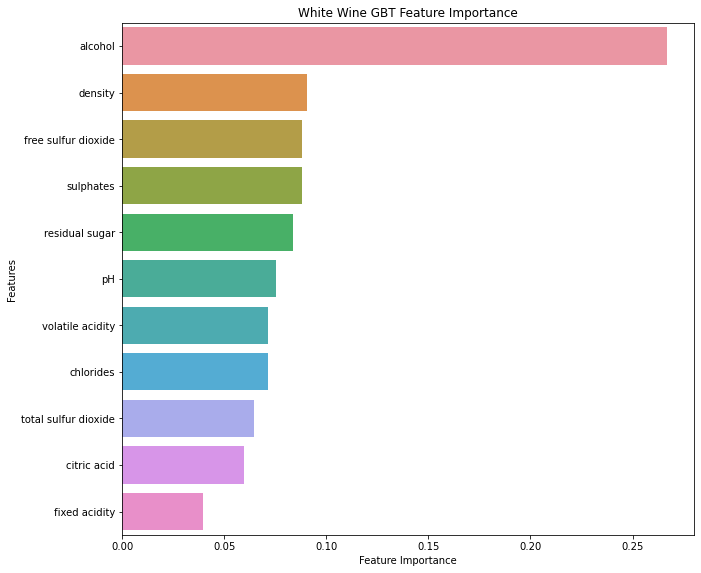

In [36]:
importance=GBT_cv_white.best_estimator_.steps[0][1].feature_importances_
pfi=plot_feature_importance(importance, X_train_white.columns, 'White Wine GBT')
save_plot(pfi, './Model Metrics/White Wine/Feature Importance/White_Wine_GBT.png')

#### Gradient Boosted Tree ROC Curve

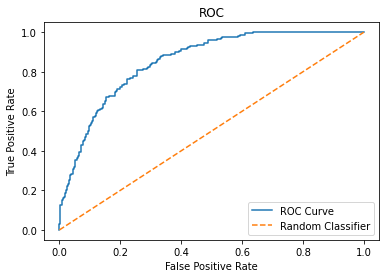

In [37]:
plot_roc(GBT_cv_white, X_test_white, y_test_white)

In [38]:
GBT_results_white=record_results('Gradient Boosted Tree', GBT_cv_white, X_test_white, y_test_white)
white_scores.append(GBT_results_white)

In [39]:
white_results= pd.DataFrame(white_scores, columns=['Model Name', 'f1 score', 'test_acc', 'roc'])
white_results.index.name='White Wine'
white_results

,Model Name,f1 score,test_acc,roc
White Wine,,,,
0,Logistic Regression,0.424000,0.818411,0.831727
1,PCA Logistic Regression,0.424000,0.818411,0.831801
2,Random Forest,0.439024,0.825977,0.863509
3,Gradient Boosted Tree,0.503401,0.815889,0.852275


## Export Model and Model Metrics

In [40]:
export_path_red='./Model Metrics/Red Wine'
export_path_white='./Model Metrics/White Wine'

In [41]:
export_file(export_path_red, '/Trained Models/logistic_regression_red.pkl', LR_cv_red)
export_file(export_path_red, '/Trained Models/PCA_logistic_regression_red.pkl', PCA_LR_cv_red)
export_file(export_path_red, '/Trained Models/random_forest_red.pkl', RF_cv_red)
export_file(export_path_red, '/Trained Models/gradient_boosted_tree_red.pkl', GBT_cv_red)
red_results.to_csv(export_path_red + '/Red_Wine_Performance_Metrics.csv',index=False)

In [42]:
export_file(export_path_white, '/Trained Models/logistic_regression_white.pkl', LR_cv_white)
export_file(export_path_white, '/Trained Models/PCA_logistic_regression_white.pkl', PCA_LR_cv_white)
export_file(export_path_white, '/Trained Models/random_forest_white.pkl', RF_cv_white)
export_file(export_path_white, '/Trained Models/gradient_boosted_tree_white.pkl', GBT_cv_white)
white_results.to_csv(export_path_white + '/White_Wine_Performance_Metrics.csv',index=False)

In [43]:
red_results

,Model Name,f1 score,test_acc,roc
Red Wine,,,,
0,Logistic Regression,0.415094,0.886029,0.867377
1,PCA Logistic Regression,0.415094,0.886029,0.861671
2,Random Forest,0.461538,0.897059,0.869913
3,Gradient Boosted Tree,0.533333,0.897059,0.877013


In [44]:
white_results

,Model Name,f1 score,test_acc,roc
White Wine,,,,
0,Logistic Regression,0.424000,0.818411,0.831727
1,PCA Logistic Regression,0.424000,0.818411,0.831801
2,Random Forest,0.439024,0.825977,0.863509
3,Gradient Boosted Tree,0.503401,0.815889,0.852275


### Conclusion

Out of our 4 models: logistic regression, logistic regression with PCA, random forest, and gradient boosted trees, it seems like the gradient boosted tree model works best with the red wine data and the random forest model wins with the white wine data.